<img src='../OUTILS/bandeau_MF.png' align='right' width='100%'/>

<div class="alert alert-info alert-success">
<h3>Manipulation des données d'imagerie avec la librairie gdal </h3></div>

## <a id='TOC-TOP'></a>Contenus

Tout d'abord, il faut procéder à l'importation des librairies nécessaires à ce TP.

In [1]:
from satpy.scene import Scene
from satpy import find_files_and_readers
from datetime import datetime
import sys
from pyresample.geometry import AreaDefinition
import numpy as np
import os
from osgeo import gdal
from PIL import Image
import subprocess
from IPython.display import display,HTML
os.environ['PATH'] = f"/opt/conda/env_MF_stage/bin:{os.environ['PATH']}" 
os.environ['GDAL_DATA'] = '/opt/conda/env_MF_stage/share/gdal'
os.environ['PROJ_LIB'] = '/opt/conda/env_MF_stage/share/proj'

Ce TP utilise en grande partie les logiciels de la librairie **"gdal"** qui signifie : *geospatial data abstraction library*. Cette librairie est extrèmement utile pour manipuler les données issues des satellites météorologiques.

Pour ce TP nous allons utiliser un fichier au format **NetCDF** issu du data store d'Eumetsat. (https://data.eumetsat.int/extended?query=msg&filter=satellite__MSG) </br>
Ces fichiers NetCDF sont proposés selon la nomenclature suivante :
W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY_MSG4+SEVIRI_C_EUMG_**AAAAMMJJHHMMSS**.nc

Le fichier que nous allons manipuler est le suivant :

**`W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY_MSG4+SEVIRI_C_EUMG_20220905120011.nc`**

Il se trouve dans ce répertoire :
**`/stockage/DATA/msg`**

La commande gdalinfo permet d'afficher les informations qui se trouvent dans le fichier NetCDF.

usage : `gdalinfo mon_fichier`

Pour lancer les commandes gdal dans ce jupyter notebook il faut les précéder d'un point d'exclamation :

`!gdalinfo`

Maintenant, faites un gdalinfo du fichier NetCDF.

In [2]:
!gdalinfo /stockage/DATA/msg/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY_MSG4+SEVIRI_C_EUMG_20220905120011.nc

Driver: netCDF/Network Common Data Format
Files: /stockage/DATA/msg/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY_MSG4+SEVIRI_C_EUMG_20220905120011.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#15_trailer_version=0x00
  NC_GLOBAL#a1=5.34278126958575e-07
  NC_GLOBAL#a2=6.096911894438815e-16
  NC_GLOBAL#attitude_period_end_time_day=23635
  NC_GLOBAL#attitude_period_end_time_msec=0
  NC_GLOBAL#attitude_period_start_time_day=23623
  NC_GLOBAL#attitude_period_start_time_msec=0
  NC_GLOBAL#bb_calibration_type=0x02
  NC_GLOBAL#bb_cal_scheduled=F
  NC_GLOBAL#bb_first_line=0
  NC_GLOBAL#bb_last_line=0
  NC_GLOBAL#bb_observation_UTC_day=23623
  NC_GLOBAL#bb_observation_UTC_masec=396
  NC_GLOBAL#bb_observation_UTC_misec=42298034
  NC_GLOBAL#bb_observation_UTC_nasec=310
  NC_GLOBAL#bodies_close_to_FOV=0x00
  NC_GLOBAL#checksum_flag=F
  NC_GLOBAL#cold_focal_plane_op_temp=95
  NC_GLOBAL#comment=Rectified (level 1.5) Meteosat SEVIRI image data. This file contains the 11 VIS-IR channels, plus the geolocation

Il y a énormément d'informations proposées. Mais nous n'allons pas toutes les exploiter.
Nous utiliserons uniquement les informations des subdataset compris entre 37 et 47.

Si on voit un NetCDF comme une armoire, un subdatset est un tiroir de cette armoire.

Pour se simplifier la tâche, nous allons définir le chemin d'accès aux données dans une variable.

In [3]:
input = '/stockage/DATA/msg/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY_MSG4+SEVIRI_C_EUMG_20220905120011.nc'

On peut vérifier à quoi correspond notre variable.

In [4]:
input

!gdalinfo $input

Driver: netCDF/Network Common Data Format
Files: /stockage/DATA/msg/W_XX-EUMETSAT-Darmstadt,VIS+IR+HRV+IMAGERY_MSG4+SEVIRI_C_EUMG_20220905120011.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#15_trailer_version=0x00
  NC_GLOBAL#a1=5.34278126958575e-07
  NC_GLOBAL#a2=6.096911894438815e-16
  NC_GLOBAL#attitude_period_end_time_day=23635
  NC_GLOBAL#attitude_period_end_time_msec=0
  NC_GLOBAL#attitude_period_start_time_day=23623
  NC_GLOBAL#attitude_period_start_time_msec=0
  NC_GLOBAL#bb_calibration_type=0x02
  NC_GLOBAL#bb_cal_scheduled=F
  NC_GLOBAL#bb_first_line=0
  NC_GLOBAL#bb_last_line=0
  NC_GLOBAL#bb_observation_UTC_day=23623
  NC_GLOBAL#bb_observation_UTC_masec=396
  NC_GLOBAL#bb_observation_UTC_misec=42298034
  NC_GLOBAL#bb_observation_UTC_nasec=310
  NC_GLOBAL#bodies_close_to_FOV=0x00
  NC_GLOBAL#checksum_flag=F
  NC_GLOBAL#cold_focal_plane_op_temp=95
  NC_GLOBAL#comment=Rectified (level 1.5) Meteosat SEVIRI image data. This file contains the 11 VIS-IR channels, plus the geolocation

La commande suivante permet d'afficher le contenu du subdataset d'un fichier NetCDF :
    
!gdalinfo NETCDF:"$input":**nom_du_subdataset**

***Exercice 1 : afficher les informations du canal IR 10,8 microns.***

Il est possible de rajouter des options à la commande gdalinfo.

l'option -mm permet d'afficher les valeurs mini et maxi des données que l'on consulte.

Questions : quels sont les valeurs mini et maxi du canal 10,8 microns et du canal 0,8 microns ?

Définissons la variable du dossier où seront stockés les résultats.

In [5]:
download_dir = os.path.join(os.getcwd(), "../RESULTS")
os.makedirs(download_dir, exist_ok=True)

In [6]:
output = '../RESULTS'

La commande suivante permet de générer un image à partir des données qui sont stockées dans le NetCDF :

Indiquer le nom du subdataset

In [7]:
nom_du_subdataset = 'ch9'

In [8]:
!gdal_translate -ot byte -scale 0 1023 0 255 NETCDF:"$input":{nom_du_subdataset} {output}/20220905_1200_IR108_0-1024.tif

Warning 1: dimension #1 (num_columns_vis_ir) is not a Longitude/X dimension.
Warning 1: dimension #0 (num_rows_vis_ir) is not a Latitude/Y dimension.
Input file size is 3712, 3712
Warning 1: for band 1, nodata value has been clamped to 0, the original value being out of range.
0...10...20...30...40...50...60...70...80...90...100 - done.


Nous allons redimensionner l'image à l'aide la commande suivante :

In [9]:
im = Image.open(output + '/20220905_1200_IR108_0-1024.tif', 'r')
image_redim = im.resize((700,700), resample=0)
image_redim.save(output + '/20220905_1200_IR108_0-1024_redim.tif')

In [10]:
!convert -resize 700 ../RESULTS/20220905_1200_IR108_0-1024_redim.tif ../RESULTS/20220905_1200_IR108_0-1024_redim.jpg 

Il est alors possible de visualiser l'image à l'aide la commande suivante :

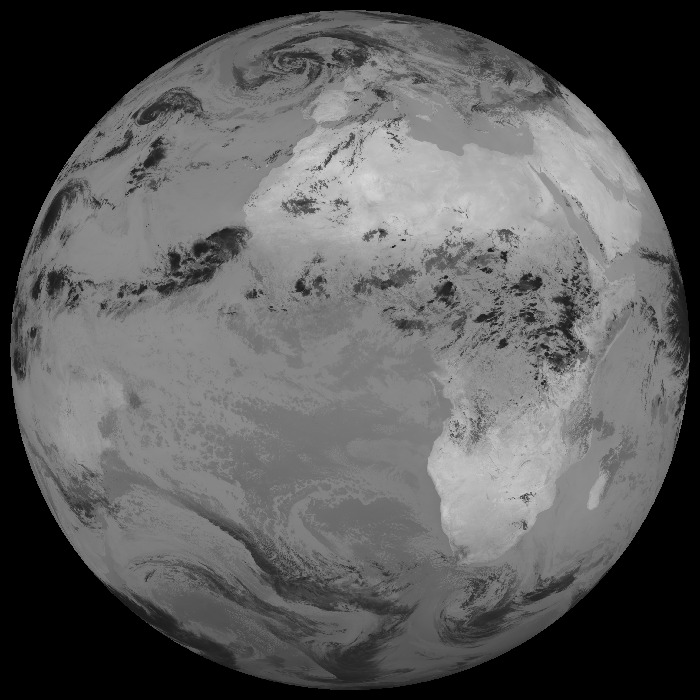

In [11]:
im = Image.open(output + '/20220905_1200_IR108_0-1024_redim.jpg', 'r')
display(im)

L'image manque de contraste.

In [12]:
!gdal_translate -ot byte -scale 0 871 0 255 NETCDF:"$input":{nom_du_subdataset} {output}/20220905_1200_IR108_min-max.tif

Warning 1: dimension #1 (num_columns_vis_ir) is not a Longitude/X dimension.
Warning 1: dimension #0 (num_rows_vis_ir) is not a Latitude/Y dimension.
Input file size is 3712, 3712
Warning 1: for band 1, nodata value has been clamped to 0, the original value being out of range.
0...10...20...30...40...50...60...70...80...90...100 - done.


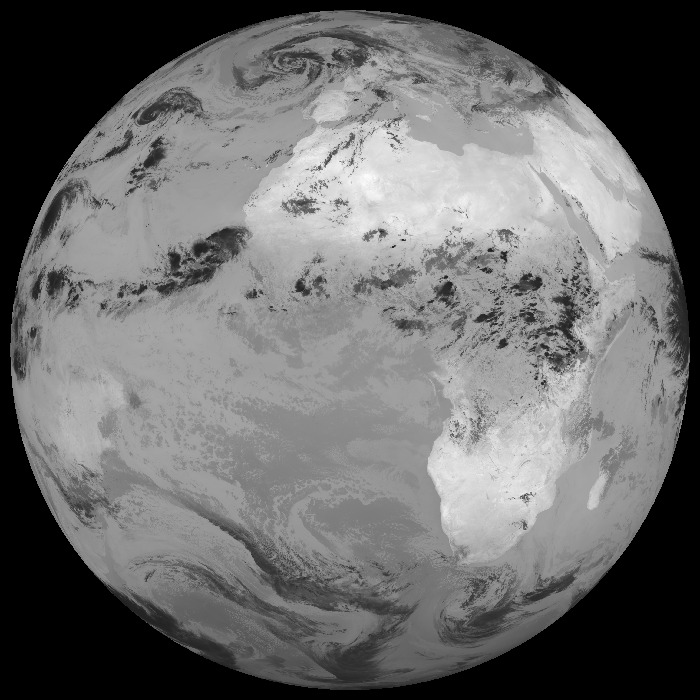

In [13]:
im = Image.open(output + '/20220905_1200_IR108_min-max.tif', 'r')
image_redim = im.resize((700,700), resample=0)
image_redim.save(output + '/20220905_1200_IR108_min-max_redim.tif')
!convert -resize 700 ../RESULTS/20220905_1200_IR108_min-max_redim.tif ../RESULTS/20220905_1200_IR108_min-max_redim.jpg
im = Image.open(output + '/20220905_1200_IR108_min-max_redim.jpg', 'r')

display(im)

La commande suivante permet de faire une RGB :

`!gdal_merge.py -separate band1.tif band2.tif band3.tif -o resultat.tif`

***Exercice 2 : faire une RGB natural color***

Faire l'exercice dans cette cellule

Effectuons un gdalinfo d'une image créée avec gdal_translate :

In [14]:
!gdalinfo $output/20220905_1200_IR108_min-max.tif

Driver: GTiff/GeoTIFF
Files: ../RESULTS/20220905_1200_IR108_min-max.tif
Size is 3712, 3712
Metadata:
  ch9#add_offset=-10.45681948659067
  ch9#comment=Radiance in mW m-2 sr-1(cm-1)-1 = add_offset + ( pixelCount * scale_factor )
  ch9#coordinates=lat lon
  ch9#long_name=SEVIRI infrared 10.8 micron pixel counts
  ch9#scale_factor=0.2050356762076601
  ch9#units=mW m-2 sr-1(cm-1)-1
  ch9#valid_max=1023
  ch9#valid_min=0
  NC_GLOBAL#15_trailer_version=0x00
  NC_GLOBAL#a1=5.34278126958575e-07
  NC_GLOBAL#a2=6.096911894438815e-16
  NC_GLOBAL#attitude_period_end_time_day=23635
  NC_GLOBAL#attitude_period_end_time_msec=0
  NC_GLOBAL#attitude_period_start_time_day=23623
  NC_GLOBAL#attitude_period_start_time_msec=0
  NC_GLOBAL#bb_calibration_type=0x02
  NC_GLOBAL#bb_cal_scheduled=F
  NC_GLOBAL#bb_first_line=0
  NC_GLOBAL#bb_last_line=0
  NC_GLOBAL#bb_observation_UTC_day=23623
  NC_GLOBAL#bb_observation_UTC_masec=396
  NC_GLOBAL#bb_observation_UTC_misec=42298034
  NC_GLOBAL#bb_observation_UTC_nas

L'image n'est pas géoréférencée. L'étape suivante va consister à géoréférencer l'image.
Chargeons les variables de géoréférencement du satellite MSG :

In [15]:
longitude=0
major_axis=6378169
minor_axis=6356583.8
hauteur=35785831
ulx=-5570248.832537
uly=5570248.832537
lrx=5567248.429179
lry=-5567248.429179

In [16]:
!gdal_translate -a_srs "+proj=geos +a=$major_axis +b=$minor_axis +lon_0=$longitude +h=$hauteur +x_0=0 +y_0=0 +pm=$longitude" -a_ullr $ulx $uly $lrx $lry $output/20220905_1200_IR108_min-max.tif $output/20220905_1200_IR108_min-max_georef.tif 

Input file size is 3712, 3712
0...10...20...30...40...50...60...70...80...90...100 - done.


Un nouveau gdalinfo donne un résultat différent

In [17]:
!gdalinfo $output/20220905_1200_IR108_min-max_georef.tif

Driver: GTiff/GeoTIFF
Files: ../RESULTS/20220905_1200_IR108_min-max_georef.tif
Size is 3712, 3712
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["unknown",
            ELLIPSOID["unknown",6378169,295.488065897001,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["unknown",0,
            ANGLEUNIT["Degree",0.0174532925199433]]],
    CONVERSION["unnamed",
        METHOD["Geostationary Satellite (Sweep Y)"],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["Degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Satellite Height",35785831,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
           

Redimensionnons l'image

In [18]:
im = Image.open(output + '/20220905_1200_IR108_min-max_georef.tif', 'r')
image_redim = im.resize((800,800), resample=0)
image_redim.save(output + '/20220905_1200_IR108_redim.tif')

In [19]:
!gdalinfo $output/20220905_1200_IR108_redim.tif

Driver: GTiff/GeoTIFF
Files: ../RESULTS/20220905_1200_IR108_redim.tif
Size is 800, 800
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,  800.0)
Upper Right (  800.0,    0.0)
Lower Right (  800.0,  800.0)
Center      (  400.0,  400.0)
Band 1 Block=800x10 Type=Byte, ColorInterp=Gray


Le géoréférencement a été perdu !!

Pour le conserver, nous pouvons redimensionner l'image à l'aide la commande gdalwarp :

In [20]:
!gdalwarp -overwrite -ts 800 800 $output/20220905_1200_IR108_min-max_georef.tif $output/20220905_1200_IR108_min-max_georef_redim.tif

Creating output file that is 800P x 800L.
Using internal nodata values (e.g. 0) for image ../RESULTS/20220905_1200_IR108_min-max_georef.tif.
Copying nodata values from source ../RESULTS/20220905_1200_IR108_min-max_georef.tif to destination ../RESULTS/20220905_1200_IR108_min-max_georef_redim.tif.
Processing ../RESULTS/20220905_1200_IR108_min-max_georef.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [21]:
!gdalinfo $output/20220905_1200_IR108_min-max_georef_redim.tif

Driver: GTiff/GeoTIFF
Files: ../RESULTS/20220905_1200_IR108_min-max_georef_redim.tif
Size is 800, 800
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["unknown",
            ELLIPSOID["unknown",6378169,295.488065897001,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["unknown",0,
            ANGLEUNIT["Degree",0.0174532925199433]]],
    CONVERSION["unnamed",
        METHOD["Geostationary Satellite (Sweep Y)"],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["Degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Satellite Height",35785831,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
       

Le géoréférencement est conservé.

On peut afficher l'image :

In [22]:
!convert -resize 700 ../RESULTS/20220905_1200_IR108_min-max_georef_redim.tif ../RESULTS/20220905_1200_IR108_min-max_georef_redim.jpg


convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


In [23]:
im = Image.open(output + '/20220905_1200_IR108_min-max_georef_redim.jpg', 'r')
display(im)

Reprojection d'une image :

In [24]:
!gdalwarp -t_srs EPSG:4326 $output/20220905_1200_IR108_min-max_georef.tif $output/20220905_1200_IR108_min-max_georef_4326.tif

Creating output file that is 3879P x 3537L.
Using internal nodata values (e.g. 0) for image ../RESULTS/20220905_1200_IR108_min-max_georef.tif.
Copying nodata values from source ../RESULTS/20220905_1200_IR108_min-max_georef.tif to destination ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif.
Processing ../RESULTS/20220905_1200_IR108_min-max_georef.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Consultons le géoréférencement :

In [25]:
!gdalinfo $output/20220905_1200_IR108_min-max_georef_4326.tif

Driver: GTiff/GeoTIFF
Files: ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif
Size is 3879, 3537
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        MEMBER["World Geodetic System 1984 (G2296)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lo

redimmensionnement de l'image a affichée

In [26]:
!convert -resize 700 $output/20220905_1200_IR108_min-max_georef_4326.tif $output/20220905_1200_IR108_min-max_georef_4326.jpg


convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


Affichons l'image.

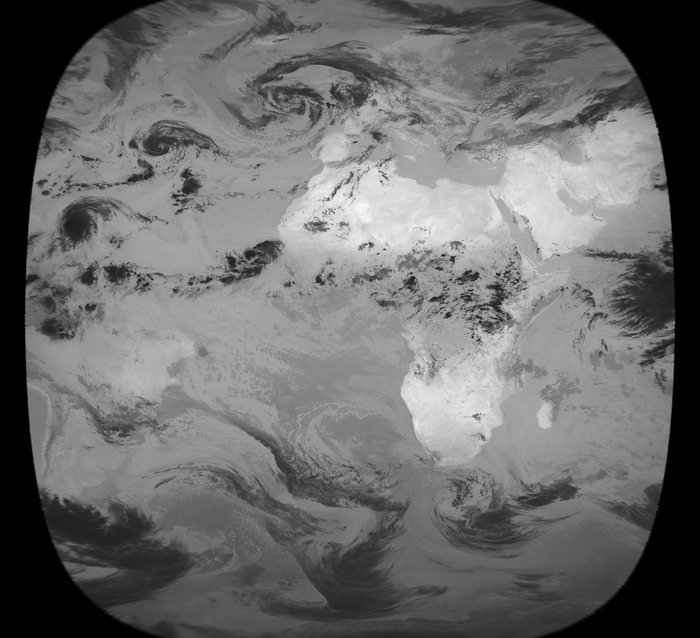

In [27]:
im = Image.open(output + '/20220905_1200_IR108_min-max_georef_4326.jpg', 'r')
display(im)

Redimensionnons l'image.

In [28]:
!gdalwarp -ts 700 700 $output/20220905_1200_IR108_min-max_georef_4326.tif $output/20220905_1200_IR108_min-max_georef_4326_redim_ts.tif

Creating output file that is 700P x 700L.
Using internal nodata values (e.g. 0) for image ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif.
Copying nodata values from source ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif to destination ../RESULTS/20220905_1200_IR108_min-max_georef_4326_redim_ts.tif.
Processing ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Que s'est-t-il passé ?

Conversion en jpg (plus léger)

In [29]:
!convert -resize 800 $output/20220905_1200_IR108_min-max_georef_4326_redim_ts.tif $output/20220905_1200_IR108_min-max_georef_4326_redim_ts.jpg


convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


In [30]:
im = Image.open(output + '/20220905_1200_IR108_min-max_georef_4326_redim_ts.jpg', 'r')
display(im)

Il faut utiliser une autre méthode.

In [31]:
!gdalwarp -tr 0.1 -0.1 $output/20220905_1200_IR108_min-max_georef_4326.tif $output/20220905_1200_IR108_min-max_georef_4326_redim_tr.tif

Creating output file that is 1626P x 1482L.
Using internal nodata values (e.g. 0) for image ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif.
Copying nodata values from source ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif to destination ../RESULTS/20220905_1200_IR108_min-max_georef_4326_redim_tr.tif.
Processing ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [32]:
!convert -resize 800 $output/20220905_1200_IR108_min-max_georef_4326_redim_tr.tif $output/20220905_1200_IR108_min-max_georef_4326_redim_tr.jpg


convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


In [33]:
im = Image.open(output + '/20220905_1200_IR108_min-max_georef_4326_redim_tr.jpg', 'r')
display(im)

gdalwarp permet de reprojeter, mais permet aussi de découper une image.
Il faut utiliser la commande :
    
`!gdalwarp -te xmin ymin xmax ymax in.tif out.tif`

***Exercice 3 : Découper une zone qui correspond à votre pays***

In [34]:
# Exemple France
!gdalwarp -te -14 38 18 56 -ts 1920 1080 -overwrite $output/20220905_1200_IR108_min-max_georef_4326.tif $output/20220905_1200_France.tif #W S E N

Creating output file that is 1920P x 1080L.
Using internal nodata values (e.g. 0) for image ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif.
Copying nodata values from source ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif to destination ../RESULTS/20220905_1200_France.tif.
Processing ../RESULTS/20220905_1200_IR108_min-max_georef_4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
!convert -resize 800 ../RESULTS/20220905_1200_France.tif ../RESULTS/20220905_1200_France.jpg


convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


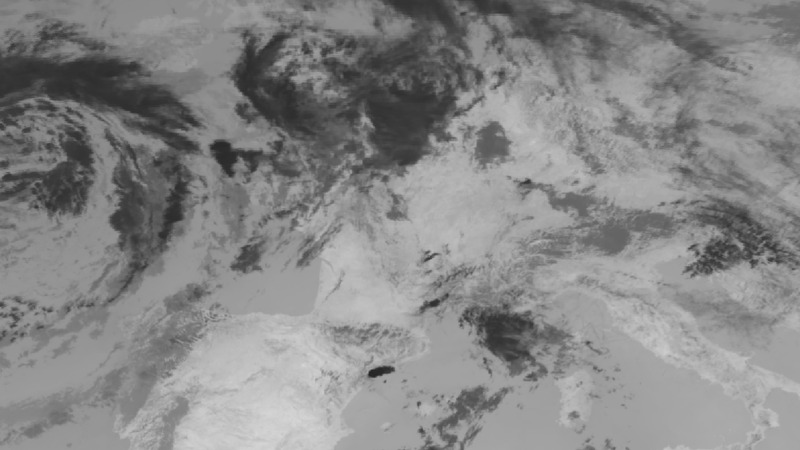

In [36]:
im = Image.open(output + '/20220905_1200_France.jpg', 'r')
display(im)

***Exercice 4 : Découper une zone au format 16X9 qui correspond à votre pays***

Cette commande permet de rajouter un shapefile sur une image.
Exemple : rajout d'un contour de cote

In [37]:
metadonnees = '../OUTILS/'

In [38]:
!gdal_rasterize -b 1 -burn 255 -l world-administrative-boundaries $metadonnees/boundary/world-administrative-boundaries.shp $output/20220905_1200_France.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


On peut aussi rajouter les graticules.

0...10...20...30...40...50...60...70...80...90...100 - done.

convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


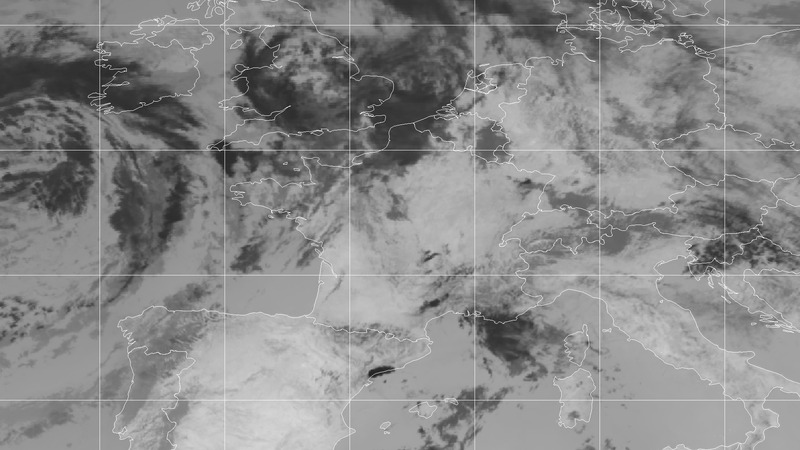

In [39]:
!gdal_rasterize -b 1 -burn 255 -l 10m-graticules-5 $metadonnees/graticules/10m-graticules-5.shp $output/20220905_1200_France.tif
!convert -resize 800 $output/20220905_1200_France.tif $output/20220905_1200_France.jpg
im = Image.open(output + '/20220905_1200_France.jpg', 'r')
display(im)

**Attention !!!**

La commande gdal_rasterize écrase l'image qui est donnée en entrée.

Visualisation de l'image :
`im = Image.open(output + '/20220905_1200_France.tif', 'r')
display(im)`

La commande suivante va permettre de seuiller les données.

`!gdal_translate -scale Inputmin Inputmax Outputmin Outputmax in.tif image_transparente.tif`

In [40]:
!gdal_translate -scale 180 255 0 255 $output/20220905_1200_France.tif $output/20220905_1200_France_seuil.tif
!convert -resize 800  $output/20220905_1200_France_seuil.tif  $output/20220905_1200_France_seuil.jpg

Input file size is 1920, 1080
0...10...20...30...40...50...60...70...80...90...100 - done.

convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


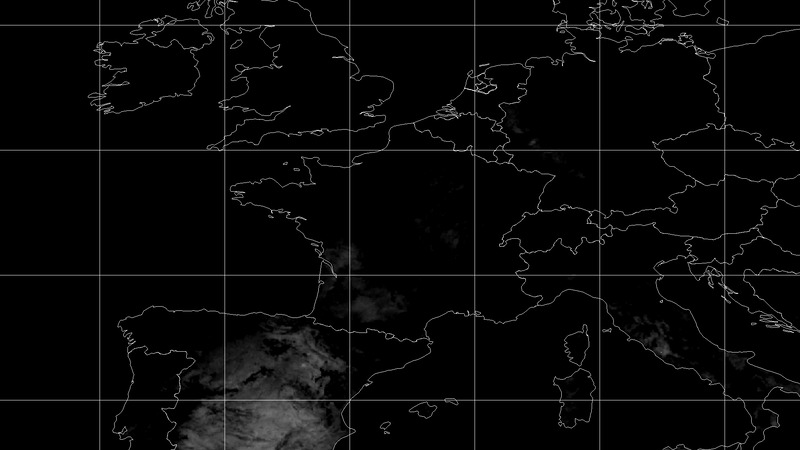

In [41]:
im = Image.open(output + '/20220905_1200_France_seuil.jpg', 'r')
display(im)

***Exercice 5 : Trouver un seuillage qui ne fasse apparaitre que les nuages***

Faire l'exercice dans cette cellule

Ensuite il est possible de mettre en transparent les zones qui sont noires :
    
`!gdalwarp -srcnodata '0' -dstalpha -dstnodata '0,0' in.tif image_transparente.tif`

In [42]:
!gdal_translate -scale 100 200 0 255 $output/20220905_1200_France.tif $output/20220905_1200_France_seuil.tif

Input file size is 1920, 1080
0...10...20...30...40...50...60...70...80...90...100 - done.


In [43]:
!gdalwarp -srcnodata '0' -dstalpha -dstnodata '0,0' $output/20220905_1200_France_seuil.tif $output/20220905_1200_France_transp.tif

Creating output file that is 1920P x 1080L.
Processing ../RESULTS/20220905_1200_France_seuil.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [44]:
!convert -resize 700  $output/20220905_1200_France_transp.tif $output/20220905_1200_France_transp.jpg


convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


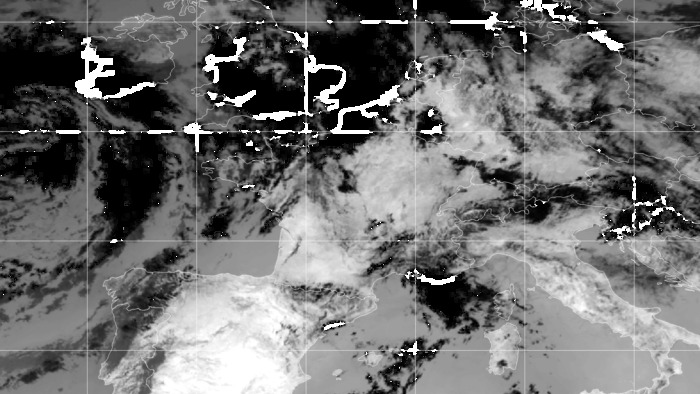

In [45]:
im = Image.open(output + '/20220905_1200_France_transp.jpg', 'r')
display(im)

Découpage d'un fond de carte sur son pays :
Exemple pour la France :

In [46]:
!gdalwarp -te -14 38 18 56 -ts 1920 1080 -overwrite ../../MF_DATA/world.200408.3x21600x10800.tif $output/Fond_france-petit.tif
!convert -resize 700  $output/Fond_france-petit.tif $output/Fond_france-petit.jpg

Creating output file that is 1920P x 1080L.
Processing ../../MF_DATA/world.200408.3x21600x10800.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/945.


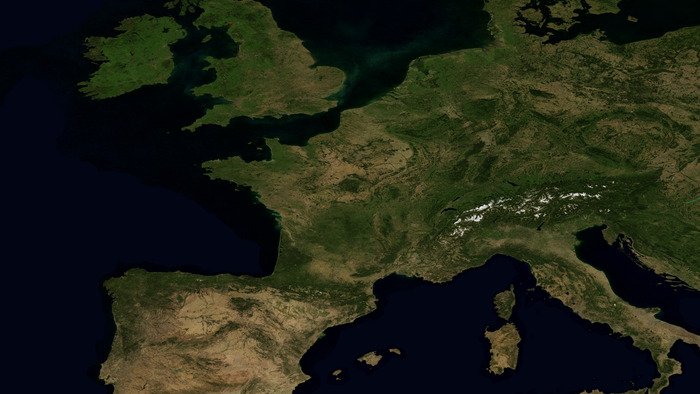

In [47]:
im = Image.open(output + '/Fond_france-petit.jpg', 'r')
display(im)

***Exercice 6 : découper un fond de carte qui correspond à la zone découpée précedemment***

superposition des nuages au fond de carte :

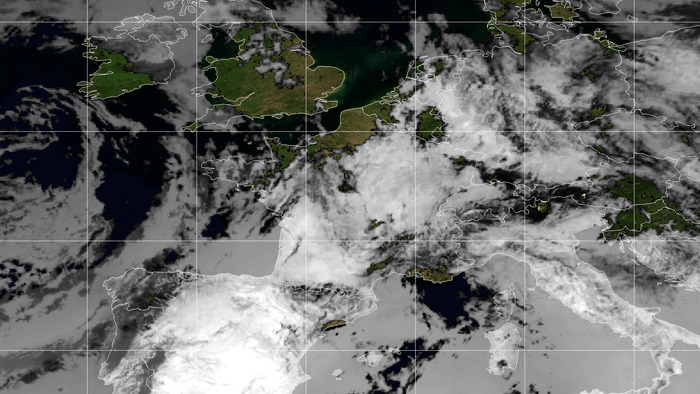

In [48]:
img = Image.open(output + '/20220905_1200_France_transp.tif', 'r')
fond = Image.open(output + '/Fond_france-petit.tif', 'r')
fond.paste(img, (0,0), img)
fond.save(output + '/20220905_1200_France_fond.tif',"TIFF")
!convert -resize 700  $output/20220905_1200_France_fond.tif $output/20220905_1200_France_fond.jpg
im = Image.open(output + '/20220905_1200_France_fond.jpg', 'r')
display(im)

Ajout d'un logo sur l'image.

In [49]:
logo1 = Image.open(metadonnees + '/Republique_Francaise_RVB.png')
petit_logo1 = logo1.resize((135,123), resample=0)
petit_logo1.save(output + '/petit_logo1.png')

In [50]:
logo2 = Image.open(metadonnees + '/logo_mf_zoom.png')
petit_logo2 = logo2.resize((123,123), resample=0)
petit_logo2.save(output + '/petit_logo2.png')

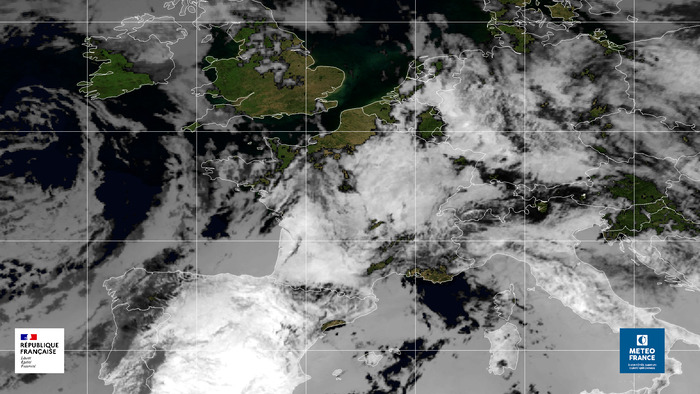

In [51]:
img = Image.open(output + '/20220905_1200_France_fond.tif', 'r')
petit_logo1 = Image.open(output + '/petit_logo1.png', 'r')
petit_logo2 = Image.open(output + '/petit_logo2.png', 'r')
img.paste(petit_logo1, (41,900))
img.paste(petit_logo2, (1700,900))
img.save(output + '/20220905_1200_France_fond_logo.tif')
!convert -resize 2000  $output/20220905_1200_France_fond_logo.tif $output/20220905_1200_France_fond_logo_HD.jpg
!convert -resize 700  $output/20220905_1200_France_fond_logo.tif $output/20220905_1200_France_fond_logo.jpg
im = Image.open(output + '/20220905_1200_France_fond_logo.jpg', 'r')
display(im)


<div class="alert alert-info" role="alert">

## <a id='section1'></a>Exercice : faire une image pour son pays avec le logo de son institution.

</div>